In [55]:
# utility
import sys
sys.path.append("..")

import utility

# data processing
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# visualization
import matplotlib.pyplot as plt

In [56]:
train_data, test_data, val_data, train_labels, test_labels, val_labels, test_true_labels = utility.preprocess_data()

In [57]:
# data shape
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

# labels shape
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)
print(test_true_labels.shape)

(20700, 784)
(6900, 784)
(6900, 784)
(20700,)
(6900,)
(6900,)
(6900,)


Dataset split: 20700 train rows
Dataset split: 20700 test rows


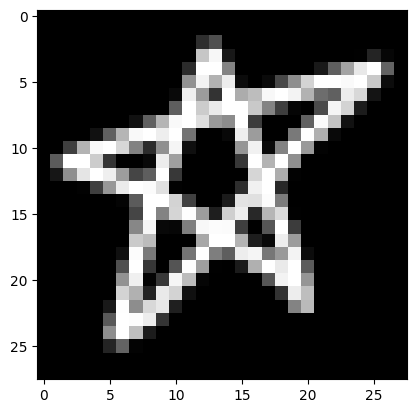

In [58]:
print(f"Dataset split: {len(train_data)} train rows")
print(f"Dataset split: {len(train_labels)} test rows")

point = train_data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [59]:
# Input layer
input_img = Input(shape=(784,))

In [60]:
# Encoder layers
encoded = Dense(256, activation='relu')(input_img)
encoded = Dropout(0.5)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)

In [61]:
# Decoder layers
decoded = Dense(64, activation='relu')(encoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [62]:
autoencoder = Model(input_img, decoded)

In [63]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [64]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = autoencoder.fit(train_data, train_data, epochs=100, batch_size=512, shuffle=True,
                          validation_data=(val_data, val_data), callbacks=[early_stopping])

Epoch 1/100


41/41 [==============================] - 2s 22ms/step - loss: 0.1390 - val_loss: 0.1350
Epoch 2/100
41/41 [==============================] - 1s 20ms/step - loss: 0.0989 - val_loss: 0.1018
Epoch 3/100
41/41 [==============================] - 1s 19ms/step - loss: 0.0933 - val_loss: 0.0955
Epoch 4/100
41/41 [==============================] - 1s 20ms/step - loss: 0.0924 - val_loss: 0.0948
Epoch 5/100
41/41 [==============================] - 1s 20ms/step - loss: 0.0919 - val_loss: 0.0948
Epoch 6/100
41/41 [==============================] - 1s 19ms/step - loss: 0.0915 - val_loss: 0.0946
Epoch 7/100
41/41 [==============================] - 1s 19ms/step - loss: 0.0913 - val_loss: 0.0946
Epoch 8/100
41/41 [==============================] - 1s 19ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 9/100
41/41 [==============================] - 1s 19ms/step - loss: 0.0908 - val_loss: 0.0941
Epoch 10/100
41/41 [==============================] - 1s 19ms/step - loss: 0.0906 - val_loss: 0.0939
Epoch 11/10

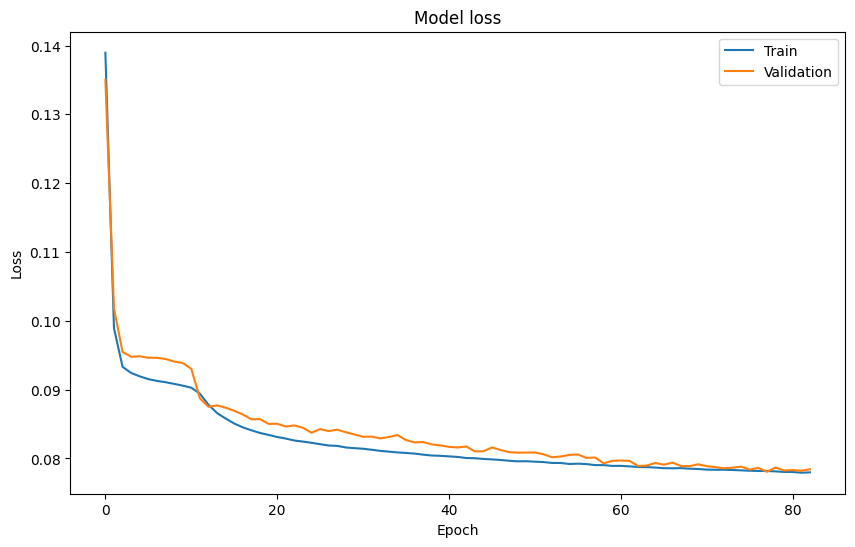

In [65]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

647/647 [==============================] - 1s 1ms/step


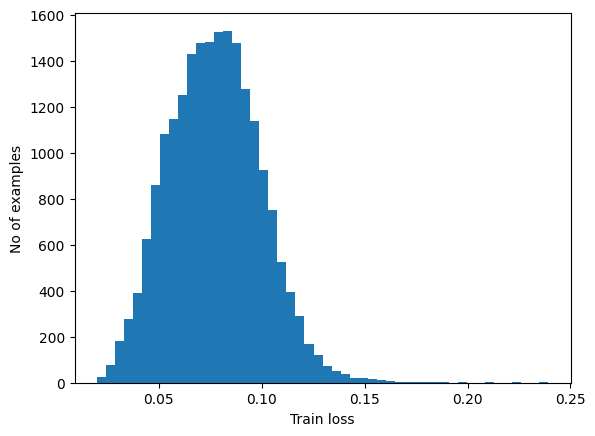

In [66]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mse(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [67]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold ", threshold)

# Choose a quantile (e.g., 99th percentile) for the threshold
threshold = np.percentile(train_loss, 99)
print("Quantile Threshold ", threshold)

Threshold  0.09974519
Quantile Threshold  0.13282537207007408


In [68]:
preds, loss, proba = utility.predict(autoencoder, test_data, threshold)

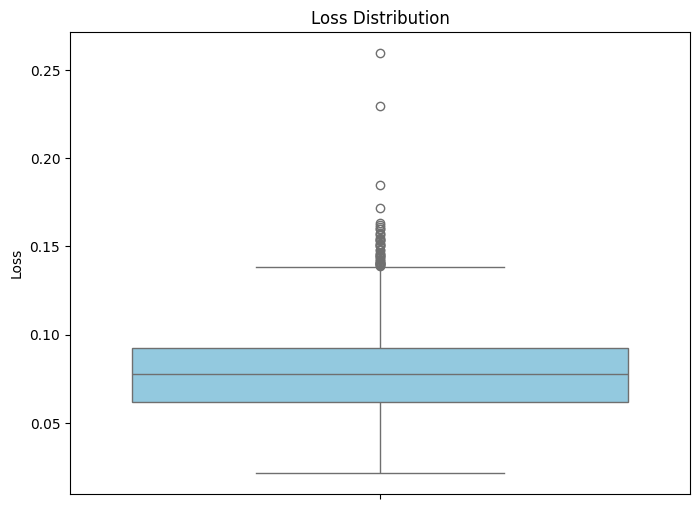

In [69]:
utility.boxplot_plot("Loss", loss)

C:\Users\zippe\AppData\Local\Temp\ipykernel_12860\1046356683.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')


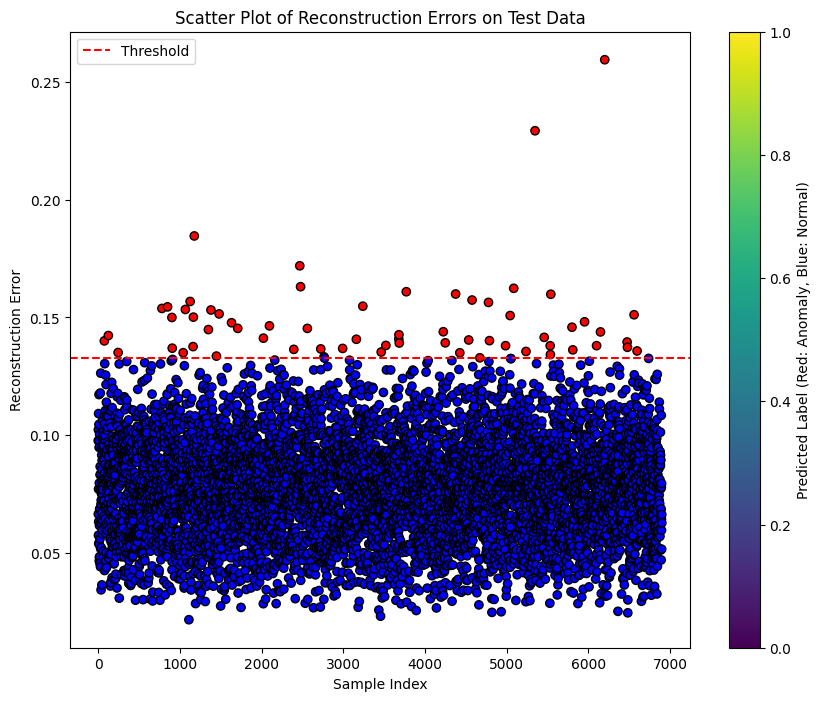

In [70]:
# Create a binary array indicating anomalies
anomaly_indicator = np.where(loss > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [71]:
a, p, r, report, cm = utility.get_metrics(preds, test_true_labels)

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [72]:
utility.print_stats(a, p, r, report, cm)

Accuracy = 0.9907246376811594
Precision = 1.0
Recall = 0.9907246376811594
Report
               precision    recall  f1-score   support

     anomaly       0.00      0.00      0.00         0
      normal       1.00      0.99      1.00      6900

    accuracy                           0.99      6900
   macro avg       0.50      0.50      0.50      6900
weighted avg       1.00      0.99      1.00      6900

Confusion Matrix
[[   0    0]
 [  64 6836]]


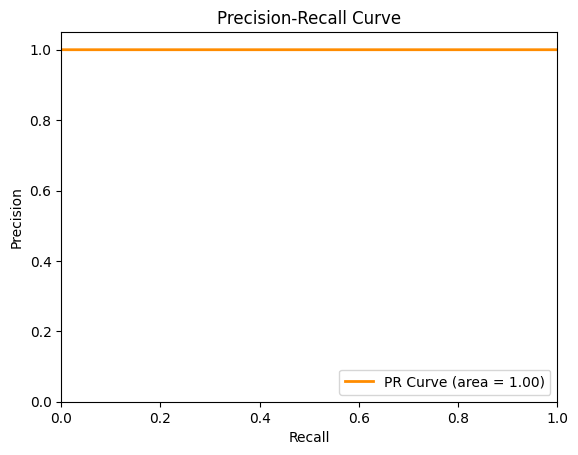

In [73]:
utility.pr_auc_plot(proba, test_true_labels)

In [74]:
utility.roc_plot(preds, test_true_labels)

Only one class present in y_true. ROC AUC score is not defined in that case.


True Negatives: 0
False Positives: 0
False Negatives: 64
True Positives: 6836


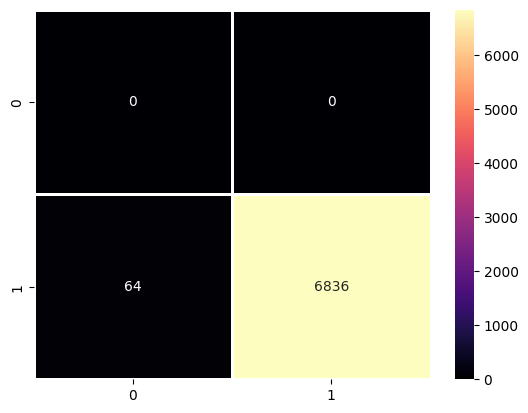

In [75]:
utility.create_heatmap(cm)

In [76]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to .\anomalies.json


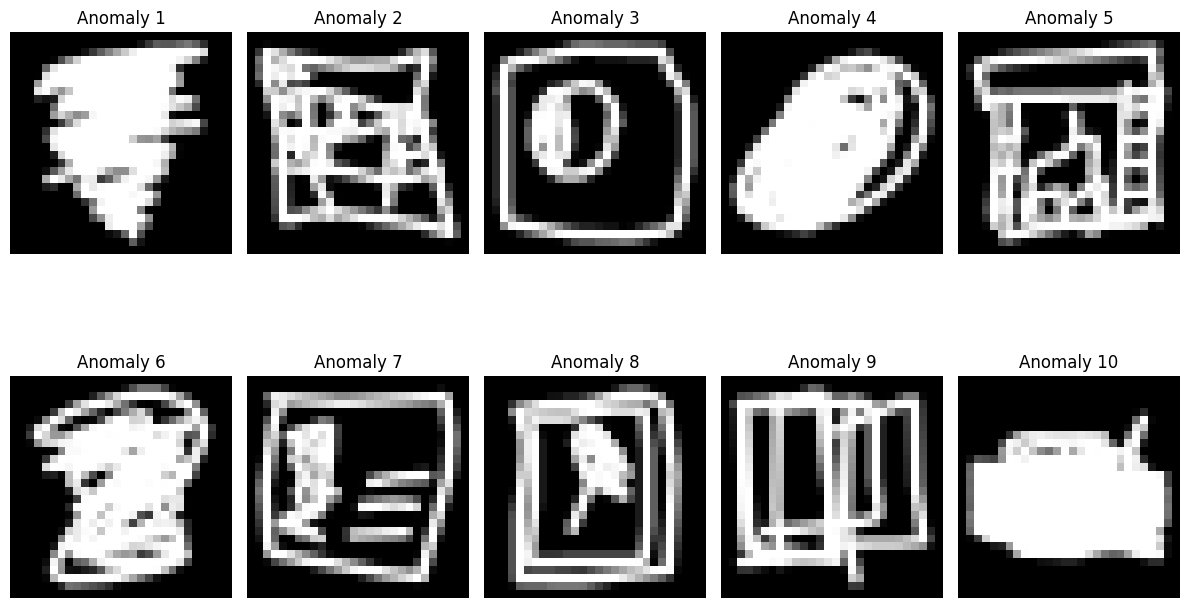

In [77]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data)